# 使用GNN进行半监督的社区发现

Almost every computer 101 class starts with a "Hello World" example. Like MNIST for deep learning, in graph domain we have the Zachary's Karate Club problem. The karate club is a social network that includes 34 members and documents pairwise links between members who interact outside the club. The club later divides into two communities led by the instructor (node 0) and the club president (node 33). The network is visualized as follows with the color indicating the community.
<img src='../asset/karat_club.png' align='center' width="400px" height="300px" />

In this tutorial, you will learn:

* Formulate the community detection problem as a semi-supervised node classification task.
* Build a GraphSAGE model, a popular Graph Neural Network architecture proposed by [Hamilton et al.](https://arxiv.org/abs/1706.02216)
* Train the model and understand the result.

In [1]:
from tutorial_utils import setup_tf
setup_tf()

In [2]:
import dgl
import tensorflow as tf
import itertools

## 使用节点分类实现社区发现

The study of community structure in graphs has a long history. Many proposed methods are *unsupervised* (or *self-supervised* by recent definition), where the model predicts the community labels only by connectivity. Recently, [Kipf et al.,](https://arxiv.org/abs/1609.02907) proposed to formulate the community detection problem as a semi-supervised node classification task. With the help of only a small portion of labeled nodes, a GNN can accurately predict the community labels of the others.

In this tutorial, we apply Kipf's setting to the Zachery's Karate Club network to predict the community membership, where only the labels of a few nodes are used.

We first load the graph and node labels as is covered in the [last session](./1_load_data.ipynb). Here, we have provided you a function for loading the data.

In [3]:
from tutorial_utils import load_zachery

# ----------- 0. load graph -------------- #
g = load_zachery()
print(g)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'club': Scheme(shape=(), dtype=tf.int64), 'club_onehot': Scheme(shape=(2,), dtype=tf.float32)}
      edata_schemes={})


In the original Zachery's Karate Club graph, nodes are feature-less. (The `'Age'` attribute is an artificial one mainly for tutorial purposes). For feature-less graph, a common practice is to use an embedding weight that is updated during training for every node.

We can use Keras's `Embedding` module to achieve this.

In [4]:
# ----------- 1. node features -------------- #
node_embed = tf.keras.layers.Embedding(g.number_of_nodes(), 5,
                                       embeddings_initializer='glorot_uniform')  # Every node has an embedding of size 5.
node_embed(1) # intialize embedding layer
inputs = node_embed.embeddings # the embedding matrix
print(inputs)

<tf.Variable 'embedding/embeddings:0' shape=(34, 5) dtype=float32, numpy=
array([[ 0.18568936,  0.24956593, -0.29168034, -0.27750796,  0.10271347],
       [-0.19641726,  0.23921284, -0.1291064 ,  0.2901238 ,  0.12351915],
       [ 0.19690016, -0.31652123, -0.01024836,  0.1292102 , -0.23551701],
       [ 0.05352545, -0.33717942, -0.155205  , -0.10800689,  0.20577553],
       [ 0.02795082, -0.10612816,  0.20633307,  0.08879638,  0.12645611],
       [-0.34818685,  0.31702647, -0.23966226,  0.05480802,  0.31978872],
       [-0.12157431, -0.21816877, -0.05451578,  0.0781244 , -0.02126244],
       [-0.16801576,  0.03256705,  0.23756239,  0.18341693, -0.15158473],
       [-0.128084  ,  0.03747481,  0.26745066, -0.16127247,  0.3117036 ],
       [-0.1780569 ,  0.3214017 ,  0.17169073,  0.10251164, -0.11105746],
       [ 0.16156206,  0.21729448,  0.25164506,  0.0230163 ,  0.27926794],
       [ 0.30207488,  0.34524927, -0.23364511, -0.3225526 , -0.19720307],
       [-0.2774266 , -0.1927522 ,  0.3

The community label is stored in the `'club'` node feature (0 for instructor, 1 for club president). Only nodes 0 and 33 are labeled.

In [5]:
labels = g.ndata['club']
labeled_nodes = [0, 33]
print('Labels', tf.gather(labels, labeled_nodes))

Labels tf.Tensor([0 1], shape=(2,), dtype=int64)


## 定义GraphSAGE模型

Our model consists of two layers, each computes new node representations by aggregating neighbor information. The equations are:

$$
h_{\mathcal{N}(v)}^k\leftarrow \text{AGGREGATE}_k\{h_u^{k-1},\forall u\in\mathcal{N}(v)\}
$$

$$
h_v^k\leftarrow \sigma\left(W^k\cdot \text{CONCAT}(h_v^{k-1}, h_{\mathcal{N}(v)}^k) \right)
$$

DGL provides implementation of many popular neighbor aggregation modules. They all can be invoked easily with one line of codes. See the full list of supported [graph convolution modules](https://docs.dgl.ai/api/python/nn.pytorch.html#module-dgl.nn.pytorch.conv).

In [6]:
from dgl.nn import SAGEConv

# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(tf.keras.layers.Layer):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, num_classes, 'mean')
    
    def call(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = tf.nn.relu(h)
        h = self.conv2(g, h)
        return h
    
# Create the model with given dimensions 
# input layer dimension: 5, node embeddings
# hidden layer dimension: 16
# output layer dimension: 2, the two classes, 0 and 1
net = GraphSAGE(5, 16, 2)

In [7]:
# ----------- 3. set up loss and optimizer -------------- #
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(100):
    
    with tf.GradientTape() as tape:
        tape.watch(inputs) # optimize embedding layer also
        
        # forward
        logits = net(g, inputs)

        # compute loss
        loss = loss_fcn(tf.gather(labels, labeled_nodes), 
                        tf.gather(logits, labeled_nodes))

        # backward
        grads = tape.gradient(loss, net.trainable_weights + node_embed.trainable_weights)        
        optimizer.apply_gradients(zip(grads, net.trainable_weights + node_embed.trainable_weights))
        all_logits.append(logits.numpy())
    
    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

Instructions for updating:
Use tf.identity instead.
In epoch 0, loss: 0.7030107975006104
In epoch 5, loss: 0.4655799865722656
In epoch 10, loss: 0.2849842309951782
In epoch 15, loss: 0.13031938672065735
In epoch 20, loss: 0.04314617067575455
In epoch 25, loss: 0.012314431369304657
In epoch 30, loss: 0.003953177481889725
In epoch 35, loss: 0.0015926912892609835
In epoch 40, loss: 0.0008075737277977169
In epoch 45, loss: 0.0004980967496521771
In epoch 50, loss: 0.00035541222314350307
In epoch 55, loss: 0.0002809925645124167
In epoch 60, loss: 0.00023797043832018971
In epoch 65, loss: 0.00021109546651132405
In epoch 70, loss: 0.00019297969993203878
In epoch 75, loss: 0.0001794522104319185
In epoch 80, loss: 0.00016872541164048016
In epoch 85, loss: 0.00015960751625243574
In epoch 90, loss: 0.00015144303324632347
In epoch 95, loss: 0.0001437552273273468


In [8]:
# ----------- 5. check results ------------------------ #
pred = tf.argmax(logits, axis=1).numpy()
print('Accuracy', (pred == labels.numpy()).sum().item() / len(pred))

Accuracy 0.4117647058823529


## 对结果进行可视化

Since the GNN produces a logit vector of size 2 for each array. We can plot to a 2-D plane.

<img src='../asset/gnn_ep0.png' align='center' width="400px" height="300px"/>
<img src='../asset/gnn_ep_anime.gif' align='center' width="400px" height="300px"/>

Run the following code to visualize the result. Require ffmpeg.

In [9]:
# A bit of setup, just ignore this cell
import matplotlib.pyplot as plt

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (4.0, 3.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['animation.html'] = 'html5'

RuntimeError: Requested MovieWriter (ffmpeg) not available

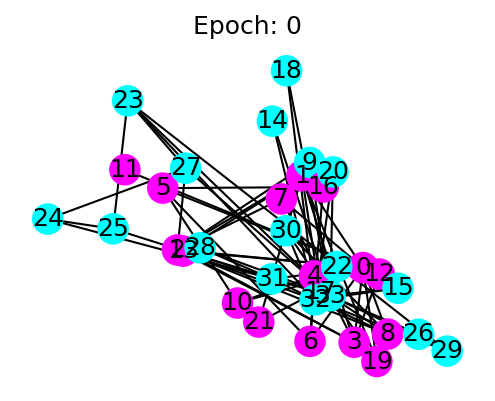

In [12]:
# Visualize the node classification using the logits output. Requires ffmpeg.
import networkx as nx
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
nx_G = g.to_networkx()
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pred = all_logits[i]
        pos[v] = pred[v]
        cls = labels[v]
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw(nx_G.to_undirected(), pos, node_color=colors, with_labels=True, node_size=200)

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())

## 课后练习

Play with the GNN models by using other [graph convolution modules](https://docs.dgl.ai/api/python/nn.pytorch.html#module-dgl.nn.pytorch.conv).